In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
from google.colab import files
uploaded=files.upload()

Saving upload_DJIA_table.csv to upload_DJIA_table.csv


In [116]:
df=pd.read_csv("Combined_News_DJIA.csv")
dj=pd.read_csv("upload_DJIA_table.csv")

In [117]:
# Combine news headlines as one column
df["combined news"]=df.loc[:,"Top1":"Top25"].astype(str).agg(" ".join,axis=1)

In [118]:
#cleaning the text column

stop = set(stopwords.words("english"))   #Load a list of common English stopwords
lemmatizer = WordNetLemmatizer()   #Load a lemmatizer, which reduces words to their root form

def clean_text(text):
    text = re.sub(r"b[\"']", " ", str(text).lower())
    text = re.sub(r"\[.*?\]\(.*?\)", "", text)
    text = re.sub(r"[^\w\s]", " ", text)  ## remove punctuation
    text = re.sub(r"\s+", " ", text)  # remove extra whitespace
    tokens = word_tokenize(text)    # tokenize into words
    output = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop]
    return " ".join(output)

# we apply a clean_text function to every row in the combined news
df["clean text"]=df["combined news"].apply(clean_text)

In [119]:

#  Define a function to get polarity and subjectivity
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

In [120]:


#  Apply the function to the "clean text" column and create two new columns
df[["Polarity", "Subjectivity"]] = df["clean text"].apply(
    lambda x: pd.Series(get_sentiment(x))
)

# Define a function to classify sentiment based on polarity
def classify_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment classification
df["Sentiment_Label"] = df["Polarity"].apply(classify_sentiment)

#  View result
print(df[["clean text", "Polarity", "Subjectivity", "Sentiment_Label"]].head())


                                          clean text  Polarity  Subjectivity  \
0  georgia down two russian warplane country move... -0.047536      0.254960   
1  wont america nato help u wont help u help iraq...  0.113565      0.346443   
2  remember adorable year old sang opening ceremo... -0.026211      0.506694   
3  u refuse israel weapon attack iran report pres...  0.014531      0.335034   
4  expert admit legalise drug war south osetia pi...  0.037480      0.344004   

  Sentiment_Label  
0        Negative  
1        Positive  
2        Negative  
3        Positive  
4        Positive  


In [121]:
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top21,Top22,Top23,Top24,Top25,combined news,clean text,Polarity,Subjectivity,Sentiment_Label
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","b""Georgia 'downs two Russian warplanes' as cou...",georgia down two russian warplane country move...,-0.047536,0.254960,Negative
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",b'Why wont America and Nato help us? If they w...,wont america nato help u wont help u help iraq...,0.113565,0.346443,Positive
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",b'Remember that adorable 9-year-old who sang a...,remember adorable year old sang opening ceremo...,-0.026211,0.506694,Negative
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,b' U.S. refuses Israel weapons to attack Iran:...,u refuse israel weapon attack iran report pres...,0.014531,0.335034,Positive
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,b'Saudi Arabia: Mother moves to block child ma...,b'Taliban wages war on humanitarian aid workers',"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...,b'All the experts admit that we should legalis...,expert ad

In [122]:
# summary of the number of rows for each sentiment
df["Sentiment_Label"].value_counts()

,count
Sentiment_Label,
Positive,1203
Negative,786


In [123]:
df.columns

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25', 'combined news', 'clean text', 'Polarity',
       'Subjectivity', 'Sentiment_Label'],
      dtype='object')

In [124]:
df=df[['Date', 'Label', 'clean text', 'Polarity',
       'Subjectivity', 'Sentiment_Label']]

In [125]:
df.head()

,Date,Label,clean text,Polarity,Subjectivity,Sentiment_Label
0,2008-08-08,0,georgia down two russian warplane country move...,-0.047536,0.254960,Negative
1,2008-08-11,1,wont america nato help u wont help u help iraq...,0.113565,0.346443,Positive
2,2008-08-12,0,remember adorable year old sang opening ceremo...,-0.026211,0.506694,Negative
3,2008-08-13,0,u refuse israel weapon attack iran report pres...,0.014531,0.335034,Positive
4,2008-08-14,1,expert admit legalise drug war south osetia pi...,0.037480,0.344004,Positive


In [126]:
dj.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [127]:
#merge the news dataset and stock price dataset
df_merged=pd.merge(df,dj,on="Date",how="inner")

In [128]:
df_merged.head()

,Date,Label,clean text,Polarity,Subjectivity,Sentiment_Label,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,0,georgia down two russian warplane country move...,-0.047536,0.254960,Negative,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1,2008-08-11,1,wont america nato help u wont help u help iraq...,0.113565,0.346443,Positive,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2,2008-08-12,0,remember adorable year old sang opening ceremo...,-0.026211,0.506694,Negative,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
3,2008-08-13,0,u refuse israel weapon attack iran report pres...,0.014531,0.335034,Positive,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
4,2008-08-14,1,expert admit legalise drug war south osetia pi...,0.037480,0.344004,Positive,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


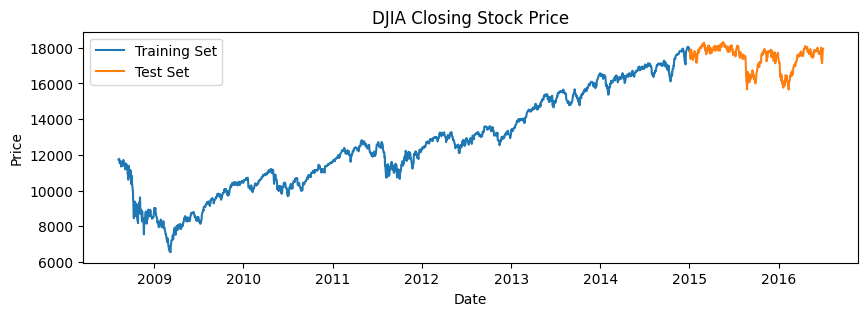

In [129]:
# we set the Date column in a datetime format
df_merged["Date"] = pd.to_datetime(df_merged["Date"])

# Split into training and testing sets
train_df = df_merged[df_merged["Date"] < "2015-01-01"]
test_df = df_merged[df_merged["Date"] >= "2015-01-01"]

# Plot the closing price
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(train_df["Date"], train_df["Close"], label="Training Set")
plt.plot(test_df["Date"], test_df["Close"], label="Test Set")
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.title("DJIA Closing Stock Price")
plt.show()

In [130]:
df_merged.columns

Index(['Date', 'Label', 'clean text', 'Polarity', 'Subjectivity',
       'Sentiment_Label', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Adj Close'],
      dtype='object')

In [131]:
features = ['Open', 'High', 'Low', 'Close', 'Volume','Polarity', 'Subjectivity']
target = 'Adj Close'
df_merged = df_merged.dropna(subset=features + [target]).reset_index(drop=True)

In [132]:
# Time-based Train/Test Split
# we split the dataset based on time and scale the data
train = df_merged[df_merged['Date'] < '2015-01-01']
test  = df_merged[df_merged['Date'] >= '2015-01-01']

# 5. Scaling
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = X_scaler.fit_transform(train[features])
y_train = y_scaler.fit_transform(train[[target]])
X_test  = X_scaler.transform(test[features])
y_test  = y_scaler.transform(test[[target]])


In [133]:
#Sequence Creation
# we creates sequences for LSTM input, because LSTMs need sequential data, so this transforms raw data into time windows.

SEQ_LEN = 10   # Convert the input data into sequences of fixed length (SEQ_LEN = 10)
#The function create_sequences() slides a window of size 10 over your data
def create_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])  # sequence of 10 days
        ys.append(y[i+seq_len])   # label is the price on the next day
    return np.array(Xs), np.array(ys)


# X_train_seq and X_test_seq become 3D arrays, the Shape is (number of sequences, sequence length, number of features)
# y_train_seq and y_test_seq become 2D arrays of the target values (next-day prices)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, SEQ_LEN)

In [134]:
#Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, X_train_seq.shape[2])), # The first LSTM layer with 128 units
    Dropout(0.1), # Prevents overfitting
    LSTM(64, return_sequences=True), #Second LSTM layer with 64 units
    Dropout(0.1),
    LSTM(32), #Third LSTM layer
    Dropout(0.1),
    Dense(1) # Output layer, predicts a single value (next day's stock price).
])

#Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse') #mse (mean squared error) for regression.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [135]:
# trains the LSTM model

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=200, # un through the entire training data up to 200 times
    batch_size=8, # processes 8 sequences at a time
    validation_split=0.1, # 10% of your training data is used as validation data to check how the model performs on unseen data
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1 #You’ll see progress printed during training
)

Epoch 1/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0215 - val_loss: 7.2425e-04
Epoch 2/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0025 - val_loss: 6.3337e-04
Epoch 3/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0020 - val_loss: 0.0049
Epoch 4/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 5/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0022 - val_loss: 8.8211e-04
Epoch 6/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0016 - val_loss: 7.2072e-04
Epoch 7/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0015 - val_loss: 6.0753e-04
Epoch 9/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0013 - val_loss: 9.0680e-04
Epoch 10/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - val_loss: 6.8471e-04
Epoch 11/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - val_loss: 9.9323e-04
Epo

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
 MSE: 45717.1476
 RMSE: 213.8157
 MAE: 164.2712
 R² Score: 0.8865
MAPE: 0.95


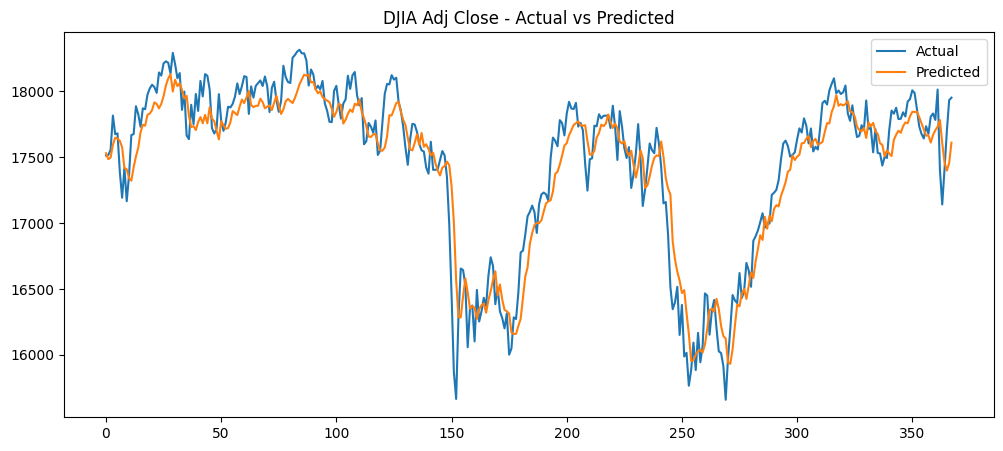

In [136]:
#evaluating the performance of trained LSTM

y_pred = model.predict(X_test_seq)
y_test_inv = y_scaler.inverse_transform(y_test_seq)
y_pred_inv = y_scaler.inverse_transform(y_pred)


#  Error Metrics
# These measure how close predictions are to real values
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)*100

print(f" MSE: {mse:.4f}")
print(f" RMSE: {rmse:.4f}")
print(f" MAE: {mae:.4f}")
print(f" R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}")

# Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title('DJIA Adj Close - Actual vs Predicted')
plt.show()


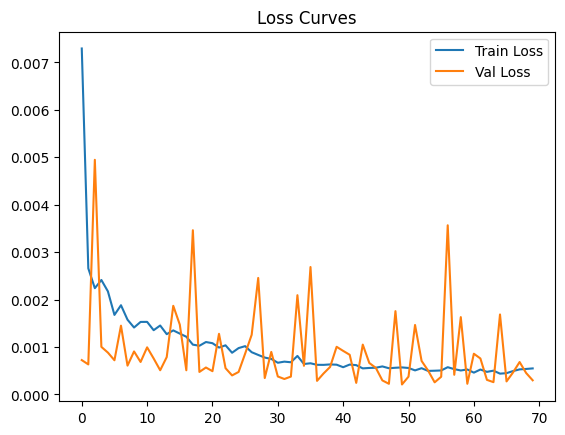

In [137]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [138]:
#we evaluate how well the LSTM model fits the training and test data using the R² score

train_preds = model.predict(X_train_seq)
val_preds = model.predict(X_test_seq)

#calculate the R² score for both predictions
print("Train R²:", r2_score(y_train_seq, train_preds))
print("Val R²:", r2_score(y_test_seq, val_preds))


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train R²: 0.9933245062325422
Val R²: 0.8864870709343486
